In [29]:
! pip install torch torchvision nltk

In [30]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
cuda


In [31]:
df = pd.read_csv('/kaggle/input/spam-or-not-spam-dataset/spam_or_not_spam.csv')
df.dropna(subset=['email'], inplace=True)

### Preprocess Function 

In [32]:
! pip install pyspellchecker

In [33]:
from spellchecker import SpellChecker

# Download necessary NLTK data
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

from nltk import pos_tag, ne_chunk
from nltk.corpus import words

# Initialize the spell checker
spell = SpellChecker()

# Function to check for ungrammatical words
def find_ungrammatical_words(text):
    # Tokenize the text into words
    tokens = word_tokenize(text)
    
    # Identify named entities using NLTK's NE chunker
    named_entities = set()
    for chunk in ne_chunk(pos_tag(tokens)):
        if hasattr(chunk, 'label') and chunk.label() in {'PERSON'}:
            named_entities.update(" ".join(c[0] for c in chunk))
    
    # Identify ungrammatical words
    ungrammatical = [word for word in tokens if word.lower() not in named_entities and spell.unknown([word])]
    
    return ungrammatical

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /usr/share/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [34]:
freq_words = {'i','url','date'}
for i in range(ord('a'),ord('z')+1):
    freq_words.add(chr(i))
    
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords and "number"
    stop_words = freq_words
    stop_words.add("number")
    ungrammatical_words = find_ungrammatical_words(text)
    for word in ungrammatical_words:
        stop_words.add(word)
    # print(stop_words)
    tokens = [word for word in tokens if (('number' not in word) and (word not in stop_words))]
    return tokens

In [35]:
# Apply preprocessing to the 'email' column
df['tokens'] = df['email'].apply(preprocess_text)

# Build vocabulary
all_tokens = [token for tokens in df['tokens'] for token in tokens]
word_counts = Counter(all_tokens)

## Prints top 40 words to check any bogus word coming frequently

# top_40_words = word_counts.most_common(100)
# print("Top 40 words based on frequency:")

# for word, count in top_40_words:
#     print(f"{word}: {count}")


# Create a vocabulary mapping from word to index
    
vocab = {word: idx+2 for idx, (word, _) in enumerate(word_counts.most_common())}
vocab['<PAD>'] = 0  # Padding token
vocab['<UNK>'] = 1  # Unknown token

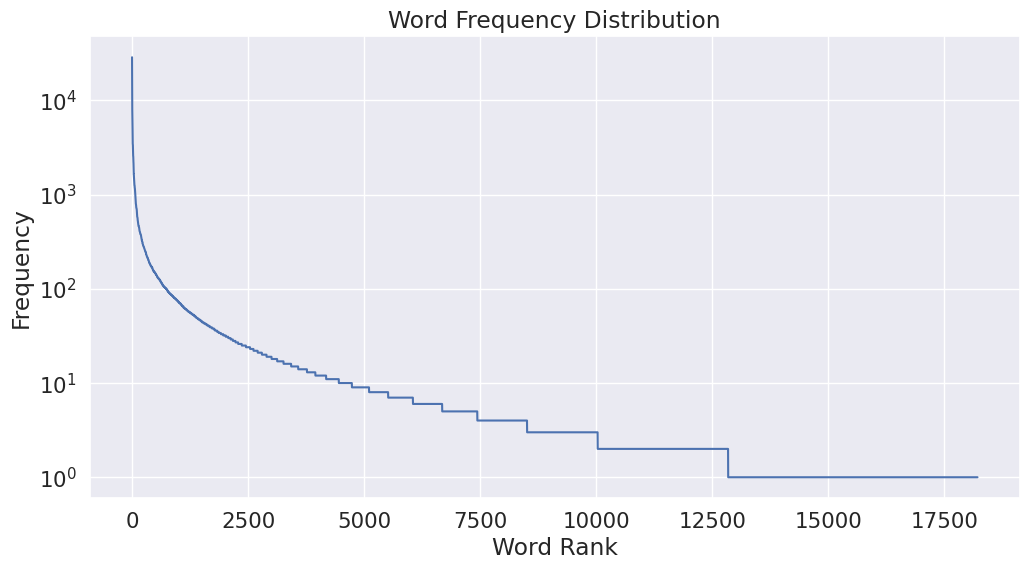

In [36]:
word_frequencies = [count for word, count in word_counts.most_common()]
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(word_frequencies) + 1), word_frequencies)
plt.title('Word Frequency Distribution')
plt.xlabel('Word Rank')
plt.ylabel('Frequency')
plt.yscale('log')  
plt.show()

In [37]:
# Convert tokens to numerical sequences
def tokens_to_seq(tokens, vocab):
    return [vocab.get(token, vocab['<UNK>']) for token in tokens]

In [38]:
df['seq'] = df['tokens'].apply(lambda tokens: tokens_to_seq(tokens, vocab))
max_seq_len = 200  
df['seq'] = df['seq'].apply(lambda seq: seq[:max_seq_len])

def pad_sequences(sequences, max_len):
    return [seq + [vocab['<PAD>']] * (max_len - len(seq)) for seq in sequences]

df['padded_seq'] = pad_sequences(df['seq'], max_seq_len)

In [39]:
classifier_train_df = df
diffusion_train_df = df.copy()

In [40]:
X = df['padded_seq'].tolist()
y = df['label'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create custom Dataset
class TextDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        seq = torch.tensor(self.sequences[idx], dtype=torch.long)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return seq, label

# Create DataLoader
batch_size = 32

train_dataset = TextDataset(X_train, y_train)
test_dataset = TextDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [41]:
# Define the Conditional LSTM-based VAE Model

class ConditionalVAE(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, latent_dim, num_classes):
        super(ConditionalVAE, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=vocab['<PAD>'])
        self.num_classes = num_classes
        
        # Encoder LSTM
        self.encoder_lstm = nn.LSTM(embedding_dim + num_classes, hidden_dim, batch_first=True)
        
        # Latent space
        self.hidden2mean = nn.Linear(hidden_dim, latent_dim)
        self.hidden2logv = nn.Linear(hidden_dim, latent_dim)
        
        # Sampling
        self.latent2hidden = nn.Linear(latent_dim + num_classes, hidden_dim)
        
        # Decoder LSTM
        self.decoder_lstm = nn.LSTM(embedding_dim + num_classes, hidden_dim, batch_first=True)
        self.outputs2vocab = nn.Linear(hidden_dim, vocab_size)
        
    def one_hot_labels(self, labels, batch_size):
        y = torch.zeros(batch_size, self.num_classes).to(device)
        y[range(batch_size), labels] = 1
        return y
        
    def encode(self, x, labels):
        embedded = self.embedding(x)
        batch_size, seq_len, _ = embedded.size()
        y = self.one_hot_labels(labels, batch_size)
        y = y.unsqueeze(1).repeat(1, seq_len, 1)
        encoder_input = torch.cat([embedded, y], dim=2)
        _, (hidden, _) = self.encoder_lstm(encoder_input)
        hidden = hidden.squeeze(0)
        mean = self.hidden2mean(hidden)
        log_var = self.hidden2logv(hidden)
        return mean, log_var
    
    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def decode(self, z, labels, seq_len):
        y = self.one_hot_labels(labels, z.size(0))
        z = torch.cat([z, y], dim=1)
        hidden = self.latent2hidden(z)
        hidden = hidden.unsqueeze(0)
        batch_size = z.size(0)
        inputs = torch.full((batch_size, seq_len), vocab['<PAD>'], dtype=torch.long).to(device)
        embedded = self.embedding(inputs)
        y = y.unsqueeze(1).repeat(1, seq_len, 1)
        decoder_input = torch.cat([embedded, y], dim=2)
        outputs, _ = self.decoder_lstm(decoder_input, (hidden, torch.zeros_like(hidden)))
        outputs = self.outputs2vocab(outputs)
        return outputs
    
    def forward(self, x, labels):
        seq_len = x.size(1)
        mean, log_var = self.encode(x, labels)
        z = self.reparameterize(mean, log_var)
        outputs = self.decode(z, labels, seq_len)
        return outputs, mean, log_var


In [42]:
# Define Diffusion based Model

class DiffusionModel(nn.Module):
        def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, seq_len, diffusion_steps=1000):
            super(DiffusionModel, self).__init__()
            self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=vocab['<PAD>'])
            self.num_classes = num_classes
            self.seq_len = seq_len
            self.hidden_dim = hidden_dim
            self.diffusion_steps = diffusion_steps
            
            # Define noise schedule
            self.beta = torch.linspace(1e-4, 0.02, diffusion_steps).to(device) 
            self.alpha = 1.0 - self.beta  
            self.alpha_cumprod = torch.cumprod(self.alpha, dim=0)  
            self.alpha_cumprod_prev = torch.cat([torch.tensor([1.0]).to(device), self.alpha_cumprod[:-1]], dim=0) 
            self.sqrt_alpha_cumprod = torch.sqrt(self.alpha_cumprod).to(device)  
            self.sqrt_one_minus_alpha_cumprod = torch.sqrt(1.0 - self.alpha_cumprod).to(device)  
            self.posterior_variance = self.beta * (1.0 - self.alpha_cumprod_prev) / (1.0 - self.alpha_cumprod)
            
            # Model to predict noise
            self.lstm = nn.LSTM(embedding_dim + hidden_dim, hidden_dim, batch_first=True, num_layers=2, dropout=0.1)
            self.output_layer = nn.Linear(hidden_dim, embedding_dim)
            
            # Timestep embedding
            self.time_mlp = nn.Sequential(
                nn.Linear(1, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim)
            )
            
            # Label embedding
            self.label_embedding = nn.Embedding(num_classes, hidden_dim)
            
        def forward_diffusion(self, x_emb, t):
            sqrt_alpha_cumprod = self.sqrt_alpha_cumprod[t].view(-1, 1, 1) 
            sqrt_one_minus_alpha_cumprod = self.sqrt_one_minus_alpha_cumprod[t].view(-1, 1, 1)  
            noise = torch.randn_like(x_emb)
            x_noisy = sqrt_alpha_cumprod * x_emb + sqrt_one_minus_alpha_cumprod * noise  
            return x_noisy, noise
        
        def predict_noise_fn(self, x_noisy, t_embed, labels_embed):
            # Concatenate timestep and label embeddings
            context = t_embed.unsqueeze(1).repeat(1, self.seq_len, 1) + labels_embed.unsqueeze(1).repeat(1, self.seq_len, 1) 
            lstm_input = torch.cat([x_noisy, context], dim=2) 
            lstm_out, _ = self.lstm(lstm_input) 
            noise_pred = self.output_layer(lstm_out)  
            return noise_pred
        
        def forward(self, x, labels):
            x_emb = self.embedding(x)  
            t = torch.randint(0, self.diffusion_steps, (x.size(0),), device=device) 
            x_noisy, noise = self.forward_diffusion(x_emb, t)  
            
            # Get timestep embedding
            t = t.float().unsqueeze(1).unsqueeze(2) / self.diffusion_steps  
            t_embed = self.time_mlp(t).squeeze(1) 
            
            # Get label embedding
            labels_embed = self.label_embedding(labels) 
            
            # Predict noise
            noise_pred = self.predict_noise_fn(x_noisy, t_embed, labels_embed)  
            
            return noise_pred, noise, t

In [43]:
# Initialize the model
vocab_size = len(vocab)
embedding_dim = 64
hidden_dim = 128
latent_dim = 32
num_classes = 2
model = ConditionalVAE(vocab_size, embedding_dim, hidden_dim, latent_dim, num_classes).to(device)

def loss_function(recon_x, x, mean, log_var,vocab_len,pad_index):
    recon_loss_fn = nn.CrossEntropyLoss(ignore_index=pad_index, reduction='sum')
    recon_x = recon_x.view(-1, vocab_size)
    x = x.view(-1)
    reconstruction_loss = recon_loss_fn(recon_x, x)
    kl_loss = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reconstruction_loss + kl_loss, reconstruction_loss, kl_loss

optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [44]:
# Training the Model

num_epochs = 12
train_loss_history = []
reconstruction_loss_history = []
kl_loss_history = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    total_reconstruction_loss = 0
    total_kl_loss = 0

    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        
        # Forward pass through the model
        recon_batch, mean, log_var = model(data, labels)
        
        # Compute the losses
        # total_loss = loss_function(
        #     recon_batch, data, mean, log_var, vocab_size, vocab['<PAD>']
        # )
        total_loss, reconstruction_loss, kl_loss  = loss_function(recon_batch, data, mean, log_var,len(vocab),vocab['<PAD>'])

        # total_loss = t_loss
        # Backward pass and optimization
        total_loss.backward()
        optimizer.step()
        
        # Aggregate losses
        train_loss += total_loss.item()
        total_reconstruction_loss += reconstruction_loss.item()
        total_kl_loss += kl_loss.item()
    
    # Average losses per token
    avg_total_loss = train_loss / (len(train_loader.dataset) * max_seq_len)
    avg_reconstruction_loss = total_reconstruction_loss / (len(train_loader.dataset) * max_seq_len)
    avg_kl_loss = total_kl_loss / (len(train_loader.dataset) * max_seq_len)

    # Store epoch losses for plotting
    train_loss_history.append(avg_total_loss)
    reconstruction_loss_history.append(avg_reconstruction_loss)
    kl_loss_history.append(avg_kl_loss)
    
    # Print epoch-level aggregated losses
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Avg Total Loss: {avg_total_loss:.4f}")
    print(f"  Avg Reconstruction Loss: {avg_reconstruction_loss:.4f}")
    print(f"  Avg KL Divergence Loss: {avg_kl_loss:.4f}")



Epoch [1/12]
  Avg Total Loss: 4.1498
  Avg Reconstruction Loss: 4.1457
  Avg KL Divergence Loss: 0.0041
Epoch [2/12]
  Avg Total Loss: 3.7283
  Avg Reconstruction Loss: 3.7244
  Avg KL Divergence Loss: 0.0039
Epoch [3/12]
  Avg Total Loss: 3.7187
  Avg Reconstruction Loss: 3.7166
  Avg KL Divergence Loss: 0.0021
Epoch [4/12]
  Avg Total Loss: 3.7146
  Avg Reconstruction Loss: 3.7136
  Avg KL Divergence Loss: 0.0010
Epoch [5/12]
  Avg Total Loss: 3.7104
  Avg Reconstruction Loss: 3.7101
  Avg KL Divergence Loss: 0.0003
Epoch [6/12]
  Avg Total Loss: 3.7081
  Avg Reconstruction Loss: 3.7080
  Avg KL Divergence Loss: 0.0001
Epoch [7/12]
  Avg Total Loss: 3.7048
  Avg Reconstruction Loss: 3.7047
  Avg KL Divergence Loss: 0.0000
Epoch [8/12]
  Avg Total Loss: 3.6989
  Avg Reconstruction Loss: 3.6989
  Avg KL Divergence Loss: 0.0000
Epoch [9/12]
  Avg Total Loss: 3.6865
  Avg Reconstruction Loss: 3.6864
  Avg KL Divergence Loss: 0.0000
Epoch [10/12]
  Avg Total Loss: 3.6700
  Avg Reconstruc

In [46]:
# Evaluate the Model

model.eval()
with torch.no_grad():
    test_loss = 0
    for data, labels in test_loader:
        data = data.to(device)
        labels = labels.to(device)
        recon_batch, mean, log_var = model(data, labels)
        total_loss,_,_ = loss_function(recon_batch, data, mean, log_var,len(vocab) , vocab['<PAD>'])
        test_loss += total_loss.item()
    
    average_test_loss = test_loss / (len(test_loader.dataset) * max_seq_len)
    print(f'Test Avg Loss per Token: {average_test_loss:.4f}')


Test Avg Loss per Token: 3.9079


# **Training of a Classifier**

In [47]:
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import time

data = classifier_train_df[['tokens', 'label']]
data = data.rename(columns={'tokens': 'email'})
X = data['email']
y = data['label']

In [48]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer(analyzer='word', token_pattern=None, tokenizer=lambda doc: doc, preprocessor=lambda doc: doc, ngram_range=(1, 2), min_df=3)

# Fit and transform the training data to a document-term matrix
X_train_tfidf = vectorizer.fit_transform(X_train)

# Transform the validation and test sets
X_val_tfidf = vectorizer.transform(X_val)
# X_test_tfidf = vectorizer.transform(X_test)

In [49]:
## Code for Hyptertuning

# from sklearn.model_selection import GridSearchCV
# from sklearn.svm import SVC
# parameters = {
#     'C': [0.005, 0.01, 0.1, 1, 10, 100, 1000],
#     'gamma': [1, 'auto', 'scale']
# }
# start_time = time.time()
# model_svm = GridSearchCV(SVC(kernel='rbf', probability=True), parameters, cv=5, n_jobs=-1).fit(X_train_tfidf, y_train)
# end_time = time.time()
# training_time = end_time - start_time
# print(f"GridSearchCV completed in {training_time:.2f} seconds")
# print("Train score:", model_svm.score(X_train_tfidf, y_train))
# print("Validation score:", model_svm.score(X_val_tfidf, y_val))

In [50]:
from sklearn.svm import SVC

# Optimal parameters (we found these after hypertuning)
best_params = {"C": 10, "gamma": 1}

# Train the SVM model with the best parameters
model_svm = SVC(kernel='rbf', probability=True, **best_params).fit(X_train_tfidf, y_train)

# Evaluate the model
print("Train score:", model_svm.score(X_train_tfidf, y_train))
print("Validation score:", model_svm.score(X_val_tfidf, y_val))


Train score: 0.9991107158737217
Validation score: 0.9826666666666667


In [51]:
torch.cuda.empty_cache()

def generate_synthetic_sentences(model, num_sentences, seq_len, label):
    model.eval()
    synthetic_sentences = []
    with torch.no_grad():
        for _ in range(num_sentences):
            z = torch.randn(1, latent_dim).to(device)
            labels = torch.tensor([label], dtype=torch.long).to(device)
            outputs = model.decode(z, labels, seq_len)
            probs = torch.softmax(outputs, dim=2)
            words = torch.multinomial(probs.squeeze(0), num_samples=1).squeeze(1)
            synthetic_sentences.append(words.cpu().numpy())
    return synthetic_sentences


In [52]:
# Generate synthetic 'not spam' emails (label=0)
num_sentences = 2000
not_spam_sequences = generate_synthetic_sentences(model, num_sentences, max_seq_len, label=0)
spam_sequences = generate_synthetic_sentences(model, num_sentences, max_seq_len, label=1)

# Convert sequences back to text
idx2word = {idx: word for word, idx in vocab.items()}

def sequence_to_text(sequence):
    words = [idx2word.get(idx, '<UNK>') for idx in sequence if idx != vocab['<PAD>']]
    return ' '.join(words)


In [53]:
generated_sentences_df = pd.DataFrame(columns = ['email','label'])

with open('synthetic_emails.txt', 'w') as file:
    file.write("Synthetic Not Spam Emails:\n")
    for i, seq in enumerate(not_spam_sequences):
        text = sequence_to_text(seq)
        new_row = pd.DataFrame({'email' : [text] , 'label' : [0]})
        
        generated_sentences_df = pd.concat([generated_sentences_df,new_row])
        
        file.write(f'Email {i+1}:\n{text}\n---\n')
    file.write("\nSynthetic Spam Emails:\n")
    for i, seq in enumerate(spam_sequences):
        text = sequence_to_text(seq)
        
        new_row = pd.DataFrame({'email' : [text] , 'label' : [1]})
        
        generated_sentences_df = pd.concat([generated_sentences_df,new_row])        
        file.write(f'Email {i+1}:\n{text}\n---\n')
print("Synthetic emails saved to 'synthetic_emails.txt'")


Synthetic emails saved to 'synthetic_emails.txt'


In [54]:

generated_sentences_df['tokens'] = generated_sentences_df['email'].apply(preprocess_text)
generated_sentences_df['email'] = generated_sentences_df['tokens']
X_test = generated_sentences_df['email']
y_test = generated_sentences_df['label']
X_test_tfidf = vectorizer.transform(X_test)

In [55]:

y_pred = model_svm.predict(X_test_tfidf)
y_pred_prob = model_svm.predict_proba(X_test_tfidf)[:, 1]

In [56]:
# Create the confusion matrix

def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)

    # Create a dataframe with the confusion matrix values
    df_cm = pd.DataFrame(cm, range(cm.shape[0]),range(cm.shape[1]))
    
    # Plot the confusion matrix
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True,fmt='.0f',cmap="YlGnBu",annot_kws={"size": 10}) # font size
    plt.show()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2000
           1       1.00      1.00      1.00      2000

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000



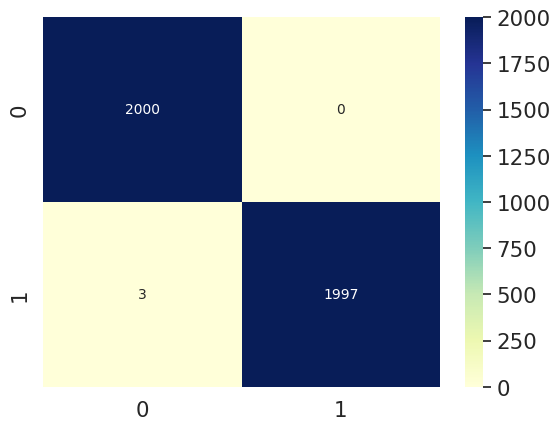

In [57]:
#print the classification report to highlight the accuracy with f1-score, precision and recall
y_test_list = y_test.to_list()
y_test_list = np.array(y_test_list)
print(metrics.classification_report(y_test_list, y_pred))

plot_confusion_matrix(y_test_list, y_pred)